In [1]:
import math
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
path = "State_of_Iowa_Salary_Book.csv"

In [3]:
def money_to_float(x):
    try:
        if type(x) == float:
            return x
        return float(x.strip('$'))
    except ValueError:
        return float('nan')

def base_salary_to_float(x):
    try:
        if type(x) == float and math.isnan(x):
            return (None, float('nan'))
        elif type(x) == float:
            return (None, x)
        x = x.strip(" ")
        if x == "":
            return (None, float('nan'))
        elif x == "TERMINATED":
            return ("TERMINATED", float('nan'))
        elif x == "Terminated":
            return ("Terminated", float('nan'))
        elif x == "-0-":
            return ("-0-", float('nan'))
        elif x == "ON LEAVE":
            return ("ON LEAVE", float('nan'))
        elif x == "nan":
            return (None, float('nan'))
        elif x == float("nan"):
            return (None, float('nan'))
        else:
            s = x.replace('/', " ").split(' ')
            if len(s) < 2:
                return (None, float(s[0].strip('$').replace(',', "")))
            return (s[1], float(s[0].strip('$').replace(',', "")))
    except:
        # this is to show rows that failed the parsing
        print("<-"+x+"->", type(x))

In [4]:
# read csv
data = pd.read_csv(path, parse_dates=[0,8], converters={'Total Salary Paid': money_to_float, 'Base Salary': base_salary_to_float, 'Travel & Subsistence': money_to_float})
# split Base Salary tuple into two columns
base_salary_parsed = data["Base Salary"].apply(pd.Series).rename(columns={0:'Base Salary Payment Method', 1:'Base Salary Payment Amount'})
data.insert(8, 'Base Salary Payment Method', base_salary_parsed['Base Salary Payment Method'])
data.insert(9, 'Base Salary Payment Amount', base_salary_parsed['Base Salary Payment Amount'])
# delete Base Salary tuple column
data.pop("Base Salary")

<-HR-> <class 'str'>
<-YR-> <class 'str'>
<-20.12HR-> <class 'str'>
<-262.99DA-> <class 'str'>


0               (HR, 31.62)
1         (TERMINATED, nan)
2              (BW, 2212.8)
3              (BW, 1226.4)
4         (TERMINATED, nan)
5         (TERMINATED, nan)
6         (TERMINATED, nan)
7         (TERMINATED, nan)
8              (BW, 2194.4)
9         (TERMINATED, nan)
10        (TERMINATED, nan)
11        (TERMINATED, nan)
12             (BW, 3375.2)
13        (TERMINATED, nan)
14        (TERMINATED, nan)
15             (BW, 3349.6)
16           (YR, 144200.0)
17             (BW, 1237.6)
18             (BW, 2908.8)
19             (BW, 3193.6)
20        (TERMINATED, nan)
21             (BW, 1598.4)
22        (TERMINATED, nan)
23        (TERMINATED, nan)
24        (TERMINATED, nan)
25        (TERMINATED, nan)
26             (BW, 1180.8)
27             (BW, 3087.2)
28             (BW, 1437.6)
29             (BW, 4792.0)
                ...        
665295          (HR, 23.91)
665296        (HR, 25629.0)
665297          (HR, 22.88)
665298    (TERMINATED, nan)
665299          (HR,

In [5]:
# shows the unique payment types
print(data["Base Salary Payment Method"].unique())

# function to estimate hourly wages and hours worked, 
def hourly_estimates(x):
    # dictionary containing conversions of method to number of hours
    method_to_hour_estimate = {'HR': 1, 'BW': 80, 'YR': 2000, 'DA': 8, 'DAILY': 8, 
                               'AN': 2000, 'HRLY': 1, 'BM': 333.33, 'PW': 40}
    # get data from row
    method, amount_per_method, total = x["Base Salary Payment Method"], x["Base Salary Payment Amount"], x["Total Salary Paid"]
    # calc hourly wage and hours worked
    try:
        hourly_wage_estimate = amount_per_method / method_to_hour_estimate.get(method, np.nan) # if the dict does not have a conversion the default is NaN
        hours_worked_estimate = total/hourly_wage_estimate
    except ZeroDivisionError:
        hourly_wage_estimate = np.nan
        hours_worked_estimate = np.nan
    # return tuple
    return hourly_wage_estimate, hours_worked_estimate
# hours_parsed is a dataframe containing all of the hourly estimates
hour_parsed = data[["Base Salary Payment Method", "Base Salary Payment Amount", "Total Salary Paid"]] \
                    .apply(hourly_estimates, axis=1).apply(pd.Series).rename(columns={0:'Hourly Wage Estimate', 1:'Hours Worked Estimate'})  # axis one means that you apply the function on the row instead of the column
# if you were to do x.values it would give you the values of the complete row
data.insert(11, 'Hourly Wage Estimate', hour_parsed['Hourly Wage Estimate'])
data.insert(12, 'Hours Worked Estimate', hour_parsed['Hours Worked Estimate'])

['HR' 'TERMINATED' 'BW' 'YR' 'DA' nan '893.00' 'DAILY' 'AN' 'ON LEAVE'
 '-0-' 'HRLY' 'BM' 'PW' '' 'Terminated']


## Main Dataframe created

### Inflation test with relation to the 2008 stock market crash

In [6]:
# Salary calculations
salary_mean = pd.DataFrame(data.groupby(["Fiscal Year"])["Total Salary Paid"].mean())
salary_increase = salary_mean.diff()/salary_mean
salary_increase_change = salary_increase.diff()

salary_mean_norm = (salary_mean-salary_mean.min())/(salary_mean.max()-salary_mean.min())
salary_increase_norm = (salary_increase-salary_increase.min())/(salary_increase.max()-salary_increase.min())
salary_increase_change_norm = (salary_increase_change-salary_increase_change.min())/(salary_increase_change.max()-salary_increase_change.min())

In [7]:
# Inflation calculations
inflation_rate_tuples = [("2007",2.3), ("2008",2.3), ("2009",1.7), ("2010",1.0), ("2011",1.7),
           ("2012",2.1), ("2013",1.8), ("2014",1.7), ("2015",1.8), ("2016",2.2), ("2017",1.8)]
inflation_rate = pd.DataFrame(inflation_rate_tuples)
inflation_rate.insert(0, 2, pd.to_datetime(pd.DataFrame(inflation_rate_tuples)[0], format='%Y'))
inflation_rate.pop(0)
inflation_rate = inflation_rate.rename({2:"Fiscal Year", 1: "Inflation Rate"}, axis=1)
inflation_rate = inflation_rate.set_index("Fiscal Year")
inflation_rate = inflation_rate/100

inflation = (inflation_rate+1).cumprod()
# inflation_rate
inflation_rate_change = inflation_rate.diff()

inflation_norm = (inflation-inflation.min())/(inflation.max()-inflation.min())
inflation_rate_norm = (inflation_rate-inflation_rate.min())/(inflation_rate.max()-inflation_rate.min())
inflation_rate_change_norm = (inflation_rate_change-inflation_rate_change.min())/(inflation_rate_change.max()-inflation_rate_change.min())

Ks_2sampResult(statistic=0.36363636363636365, pvalue=0.3743691294470314)


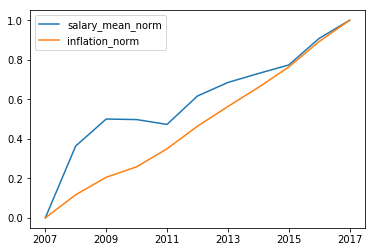

Ks_2sampResult(statistic=0.8, pvalue=0.0012162112998959323)


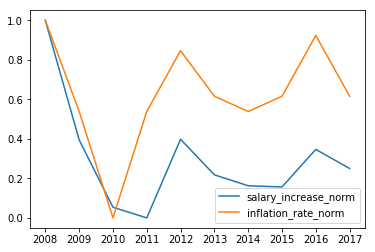

Ks_2sampResult(statistic=0.22222222222222227, pvalue=0.9574745441329627)


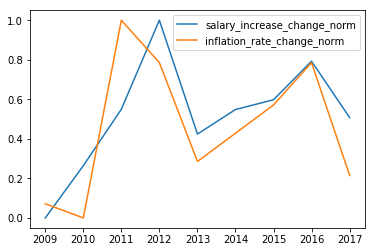

In [53]:
r = stats.ks_2samp(salary_mean_norm["Total Salary Paid"], inflation_norm["Inflation Rate"])
print(r)
plt.plot(salary_mean_norm)
plt.plot(inflation_norm)
plt.legend(["salary_mean_norm", "inflation_norm"])
plt.show()

r = stats.ks_2samp(salary_increase_norm[1:]["Total Salary Paid"], inflation_rate_norm[1:]["Inflation Rate"])
print(r)
plt.plot(salary_increase_norm[1:])
plt.plot(inflation_rate_norm[1:])
plt.legend(["salary_increase_norm", "inflation_rate_norm"])
plt.show()

r = stats.ks_2samp(salary_increase_change_norm[2:]["Total Salary Paid"], inflation_rate_change_norm[2:]["Inflation Rate"])
print(r)
plt.plot(salary_increase_change_norm[2:])
plt.plot(inflation_rate_change_norm[2:])
plt.legend(["salary_increase_change_norm", "inflation_rate_change_norm"])
plt.show()

These plots show that total inflation moves with total salary over time. Also that the change in inflation rate moves with the change of salary increases.

In [14]:
inflation_rate = pd.DataFrame(inflation_rate_tuples)
inflation_rate.insert(0, 2, pd.to_datetime(pd.DataFrame(inflation_rate_tuples)[0], format='%Y'))
inflation_rate.pop(0)
inflation_rate = inflation_rate.rename({2:"Fiscal Year", 1: "Inflation Rate"}, axis=1)
inflation_rate = inflation_rate.set_index("Fiscal Year")
inflation_rate = inflation_rate/100

inflation = (inflation_rate+1).cumprod()
# inflation_rate
inflation_rate_change = inflation_rate.diff()

inflation_norm = (inflation-inflation.min())/(inflation.max()-inflation.min())
inflation_rate_norm = (inflation_rate-inflation_rate.min())/(inflation_rate.max()-inflation_rate.min())
inflation_rate_change_norm = (inflation_rate_change-inflation_rate_change.min())/(inflation_rate_change.max()-inflation_rate_change.min())

In [15]:
pd.to_datetime(pd.DataFrame(inflation_rate_tuples)[0], format='%Y')

0    2007-01-01
1    2008-01-01
2    2009-01-01
3    2010-01-01
4    2011-01-01
5    2012-01-01
6    2013-01-01
7    2014-01-01
8    2015-01-01
9    2016-01-01
10   2017-01-01
Name: 0, dtype: datetime64[ns]

In [16]:
inflation_norm = (inflation-inflation.min())/(inflation.max()-inflation.min())

In [17]:
inflation_norm

,Inflation Rate
Fiscal Year,
2007-01-01,0.000000
2008-01-01,0.117102
2009-01-01,0.205647
2010-01-01,0.258617
2011-01-01,0.349568
2012-01-01,0.463828
2013-01-01,0.563822
2014-01-01,0.659961
2015-01-01,0.763486


In [18]:
salary_increase

,Total Salary Paid
Fiscal Year,
2007-01-01,NaN
2008-01-01,0.143402
2009-01-01,0.050956
2010-01-01,-0.001022
2011-01-01,-0.009262
2012-01-01,0.051468
2013-01-01,0.024015
2014-01-01,0.015565
2015-01-01,0.014664


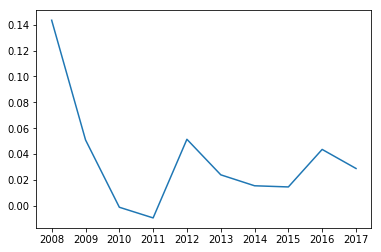

In [19]:
plt.plot(salary_increase)

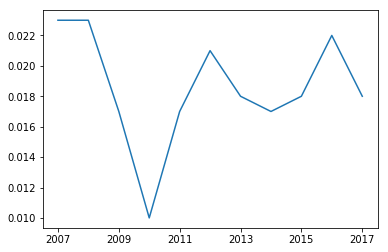

In [20]:
plt.plot(inflation_rate)

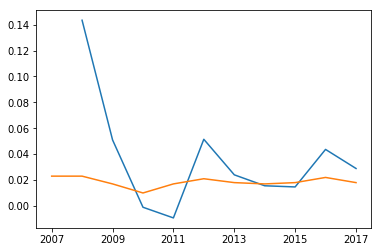

In [21]:
plt.plot(salary_increase)
plt.plot(inflation_rate)
plt.show()

In [22]:
inflation_rate_norm = (inflation_rate-inflation_rate.min())/(inflation_rate.max()-inflation_rate.min())

In [23]:
salary_increase_norm = (salary_increase-salary_increase.min())/(salary_increase.max()-salary_increase.min())

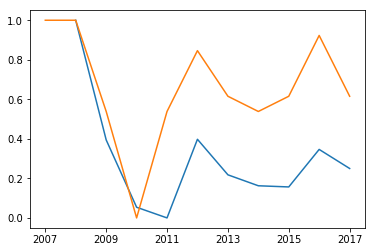

In [24]:
plt.plot(salary_increase_norm)
plt.plot(inflation_rate_norm)
plt.show()

In [25]:
stats.ks_2samp(salary_increase_norm["Total Salary Paid"][1:], inflation_rate_norm["Inflation Rate"][1:])

Ks_2sampResult(statistic=0.8, pvalue=0.0012162112998959323)

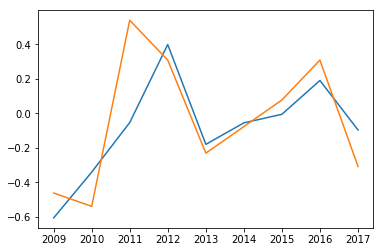

In [26]:
plt.plot(salary_increase_norm[1:].diff())
plt.plot(inflation_rate_norm[1:].diff())
plt.show()

In [27]:
stats.ks_2samp(salary_increase_norm[1:].diff()["Total Salary Paid"], inflation_rate_norm[1:].diff()["Inflation Rate"])

Ks_2sampResult(statistic=0.20000000000000007, pvalue=0.9747892465409951)

In [28]:
salary_increase_norm["Total Salary Paid"]

Fiscal Year
2007-01-01         NaN
2008-01-01    1.000000
2009-01-01    0.394446
2010-01-01    0.053975
2011-01-01    0.000000
2012-01-01    0.397800
2013-01-01    0.217975
2014-01-01    0.162628
2015-01-01    0.156719
2016-01-01    0.346516
2017-01-01    0.250028
Name: Total Salary Paid, dtype: float64

In [29]:
salary_increase_norm["Total Salary Paid"], inflation_rate_norm["Inflation Rate"]

(Fiscal Year
 2007-01-01         NaN
 2008-01-01    1.000000
 2009-01-01    0.394446
 2010-01-01    0.053975
 2011-01-01    0.000000
 2012-01-01    0.397800
 2013-01-01    0.217975
 2014-01-01    0.162628
 2015-01-01    0.156719
 2016-01-01    0.346516
 2017-01-01    0.250028
 Name: Total Salary Paid, dtype: float64, Fiscal Year
 2007-01-01    1.000000
 2008-01-01    1.000000
 2009-01-01    0.538462
 2010-01-01    0.000000
 2011-01-01    0.538462
 2012-01-01    0.846154
 2013-01-01    0.615385
 2014-01-01    0.538462
 2015-01-01    0.615385
 2016-01-01    0.923077
 2017-01-01    0.615385
 Name: Inflation Rate, dtype: float64)

In [30]:
pd.DataFrame()

""
